## Data Anonymization
Popular data anonymization algorithms. <br><br>

We can combine multiple **quasi identifiers** to form a **super identifier**,  which can identify the unique person from a dataset. <br>
So our intention is to generalize the values in quasi identifiers with minimum information loss.<br>
Also it helps us to protect the **sensitive attributes**. Also it will work in a scenario where we don't have a clear distinction between the quasi-identifiers and sensitive attributes.

<br><br>

At the end of K-anonymization, there will no individuals with distinct quasi-identifier values. <br>
So the min number of members in such a group will be K. <br>
Still a person with background knowledge can identify the unique individuals by looking at the values in sensitive attributes. To solve this we will use **L-diversity**. <br>
In L-diversity, it will ensure that there will be atleast L different values in the sensitive attribute.
Note that it is not considering the distribution of these values.

<br><br>
Still we can identify the sensitive attribute values of the person using **probabilistic reasoning**. <br>
For example there are 4/5 people in a group have same value for the sensitive attribute. So the attacker can reason that a given person who he/she knows is part of the group will -with high probability- possess that value. <br>
To solve this **t-closeness** is used.

>t-closeness demands that the statistical distribution of the sensitive attribute values in each k-anonymous group is "close" to the overall distribution of that attribute in the entire dataset.

Typically, the closeness can be measured using e.g. the **Kullback-Leibler (KL) divergence**. An adversary could then only learn a limited amount of information from comparing the distribution of the values in the group to the distribution in the entire dataset.

## Implementation
Optimal partition into k-anonymous groups is an **NP-hard problem**. <br>
Practical methode is to use **greedy search techniques** to find the optimal solution.


### Mondrian algorithm
Here we will use Mondrian algorithm as a greedy search algorithm. <br>
In this method we will parition the original data into smaller and smaller groups (in 2D plot it looks like Piet Mondrian). <br>
The algorithm assumes that,
* we converted all values into numeric or categorical form.
* we are able to measure the span of a given attribute $X_i$


### Partitioning
For k-anonymization the algorithm works like,

let $P_{finished}$ is finished set of partitions and $P_{working} is working set of partitions

1. Initialize $P_{finished} = \{\}$. 
2. Initialize $P_{working} = \{\{1, 2,\dots ,N\}\}$ with entire dataset.
3. While there are partitions in $P_{working}$, pop one partition from it.
    * calculate relative spans of all columns in the partition.
    * Sort the columns by their spans (in ascending order). <br>
      For each column,
      * Split the column along the median(split point) of that column.
      * check if the resulting partitions are valid, with our K-anonymization (or other) algorithm.
      * If yes, add the two new partitions to the $P_{working}$ and break the loop.
    * If no column produced a valid split, add the original partition to $P_{finished}$
4. return $P_{finished}$. 

### Data Aggregation
When we find that the data partition violates k-anonymization, we need to anonymize it. <br>
The method for anonymizing the data is aggregation (genarilizing the values). <br>
Agreegation for,
* **numeric attributes** is done by replacing them with their range **(e.g. "age: 24-28")**.
* **categorical attributes** is done with their union **(e.g. "employment-group: [self-employed, employee, worker]")**.

<br>

Methods like [Anatomy](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.156.9150&rep=rep1&type=pdf) even preserve the micro-data in each group, which increases re-identification risk though.

### Usage of the anonymized data
* to create **Privacy precerving machine learning models**.
* they are same as the original data, so can be used to create **data visualizations**.
* for **testing load** of the systems.
* to release the data publically.


In [0]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# read the dataset
dataset = pd.read_csv('adults_all.csv')

In [199]:
# shape of the data
print('Shape of the dataset : ',dataset.shape)

Shape of the dataset :  (48842, 15)


In [200]:
# sample data
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


In [201]:
# columns
attributes = dataset.columns.values
attributes

array(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'], dtype=object)

In [202]:
# categorical attributes
categorical = dataset.select_dtypes(include=['object', 'category']).columns.values
categorical

array(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype=object)

In [0]:
# set all categorical features data type as 'category'
for attribute in categorical:
  dataset[attribute] = dataset[attribute].astype('category')

**Now define some methods to return the span of the columns.**

In [0]:
# helper method to return the span of the columns
# it will return span for each partition
# span for numeric - is the difference b/w max and min values of the column (in that partition)
# span for categorical - is the unique values for the attribute (in that partition)
# scale - is an array. If you spacify the scale, then it will devide the values in attribute with it
def get_spans(dataset, partition, scale=None):
  spans = {}
  for column in dataset.columns:
    if column in categorical:
      span = len(dataset[column][partition].unique())
    else:
      span = dataset[column][partition].max() - dataset[column][partition].min()
    if scale is not None:
      span = span/scale[column]
    spans[column] = span
  return spans

In [205]:
all_spans = get_spans(dataset, dataset.index)
all_spans

{'age': 73,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'education': 16,
 'education-num': 15,
 'fnlwgt': 1478115,
 'hours-per-week': 98,
 'income': 2,
 'marital-status': 7,
 'native-country': 42,
 'occupation': 15,
 'race': 5,
 'relationship': 6,
 'sex': 2,
 'workclass': 9}

**Create split methode, which will split the dataset into two partitions wrt a column along it's median.** <br>
**So the values below median will be in one partition and above or equal median will be in other.**

In [0]:
def split(dataset, partition, column):
  partition = dataset[column][partition]
  if column in categorical:
    # if categorical, simply devide the column into two halves (irrespective of distributions of values)
    values = partition.unique()
    lv = set(values[:len(values)//2]) # first half of column
    rv = set(values[len(values)//2:])
    return partition.index[partition.isin(lv), partition.isin(rv)]
  else:
    median = partition.median()
    partition_1 = partition.index[partition < median]
    partition_2 = partition.index[partition >= median]
    return (partition_1, partition_2)

### Partitioning of the dataset
We have defined the essential helper methods. <br>
**Let's implement the partition algorithm, using K-anonymization as the criterion for partitioning.**

In [0]:
# the criteria
def is_k_anonymous(dataset, partition, sensitive_column, k=3):
  if len(partition) < k:
    return False
  else:
    return True

# methode for partition, note that the 'is_valid' parameter is the 'is_k_anonymous' method itself
def partition_dataset(dataset, feature_columns, sensitive_column, scale, is_valid):
  finished_partitions = []
  partitions = [dataset.index] # is the dataset itself as a single partition

  while partitions:
    partition = partitions.pop()
    spans = get_spans(dataset[feature_columns], partition, scale)
    for column, span in sorted(spans.items(), key=lambda x:-x[1]):
      lp, rp = split(dataset, partition, column)
      if not is_valid(dataset, lp, sensitive_column) or not is_valid(dataset, rp, sensitive_column):  
        continue       # if any one of them is anonymous confirm the split
      partitions.extend((lp, rp)) # and add the dataset to working set
      break
    else:
      finished_partitions.append(partition) # if there is no valid split, add them to the finished set
  return finished_partitions


In [0]:
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(dataset, feature_columns, sensitive_column, all_spans, is_k_anonymous)

In [209]:
len(finished_partitions)

500

### Visualize the dataset
Let's visualize the partitions. <br>
If we perform the partition only along the two columns selected for plotting then the resulting rects should not overlap and cover the entire dataset.

In [0]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [0]:
# helper methods

# will return list of unique values(the classes) with unique numbers assigned to them
def build_indices(dataset):
  indices = {}
  for column in categorical:
    values = sorted(dataset[column].unique())
    indices[column] = {x:y for x, y in zip(values, range(len(values)))}
  return indices

# as the above method is throwing error for 'income', becoz 'income' contains special characters like '<' and sorted method can't handle that
dataset['income'] = dataset[attribute].astype(str)


# get the co-ordinated of partition for plotting it (note that it will return a pair of co-ordinates only)
def get_coords(dataset, column, partition, indices, offset=0.1):
  if column in categorical:
    sv = dataset[column][partition].sort_values() # sort the values in a column
    l, r = indices[column][sv[sv.index[0]]], indices[column][sv[sv.index[-1]]]+1.0 # there are indices (numbers) asigned to each class in an attribute
                                                                    # so above will return for 'workclass'(categorical)  (0, 8) --> (0, 9) as we added 1.0 
  else:
    # if numerical
    sv = dataset[column][partition].sort_values() # sorted
    next_value = sv[sv.index[-1]] # upper bound (ofcource it is the max value)
    larger_values = dataset[dataset[column] > next_value][column] # probabily it is [] (empty), as next_value is the largest value in the column
    if len(larger_values) > 0:
      # if not empty
      next_value = larger_values.min() # re assign next_value as the next large value found
    l = sv[sv.index[0]]
    r = next_value
  # to make the partition more visible, let's add some offset
  l -= offset
  r += offset
  return l, r


# get rectangles for partitions
def get_partition_rects(dataset, partitions, column_x, column_y, indices, offsets=[0.1, 0.1]):  #  not that 'partitions' (not one) passed
  rects = []
  for partition in partitions:
    xl, xr = get_coords(dataset, column_x, partition, indices, offset=offsets[0])
    yl, yr = get_coords(dataset, column_y, partition, indices, offset=offsets[1])
    rects.append(((xl, yl), (xr, yr)))
  return rects 


# the boundaries of features
def get_bounds(dataset, column, indices, offset=1.0):
  if column in categorical:
    return 0-offset, len(indices[column])+offset  # negative offset, len(indices)+offset
  return dataset[column].min()-offset, dataset[column].max()+offset  # if numerical

In [0]:
# let's calculate the bounding rectangles of all the partitions that we created
indices = build_indices(dataset)

column_x, column_y = feature_columns[:2]
rects = get_partition_rects(dataset, finished_partitions, column_x, column_y, indices, offsets=[0.0, 0.0])

In [213]:
# let's look at the rects created
rects[:10]

[((88.0, 15.0), (90.0, 16.0)),
 ((90.0, 14.0), (90.0, 15.0)),
 ((81.0, 14.0), (87.0, 16.0)),
 ((79.0, 16.0), (81.0, 16.0)),
 ((79.0, 15.0), (81.0, 16.0)),
 ((79.0, 14.0), (81.0, 15.0)),
 ((77.0, 14.0), (79.0, 16.0)),
 ((76.0, 14.0), (77.0, 16.0)),
 ((88.0, 13.0), (90.0, 14.0)),
 ((80.0, 13.0), (86.0, 14.0))]

In [0]:
# plot the rectangles
def plot_rects(dataset, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
  for (xl, yl), (xr, yr) in rects:
    ax.add_patch(patches.Rectangle( (xl, yl), xr-xl, yr-yl, linewidth=1, edgecolor=edgecolor, facecolor=facecolor, alpha=0.5 ))
  ax.set_xlim(*get_bounds(dataset, column_x, indices))
  ax.set_ylim(*get_bounds(dataset, column_y, indices))
  ax.set_xlabel(column_x)
  ax.set_ylabel(column_y)

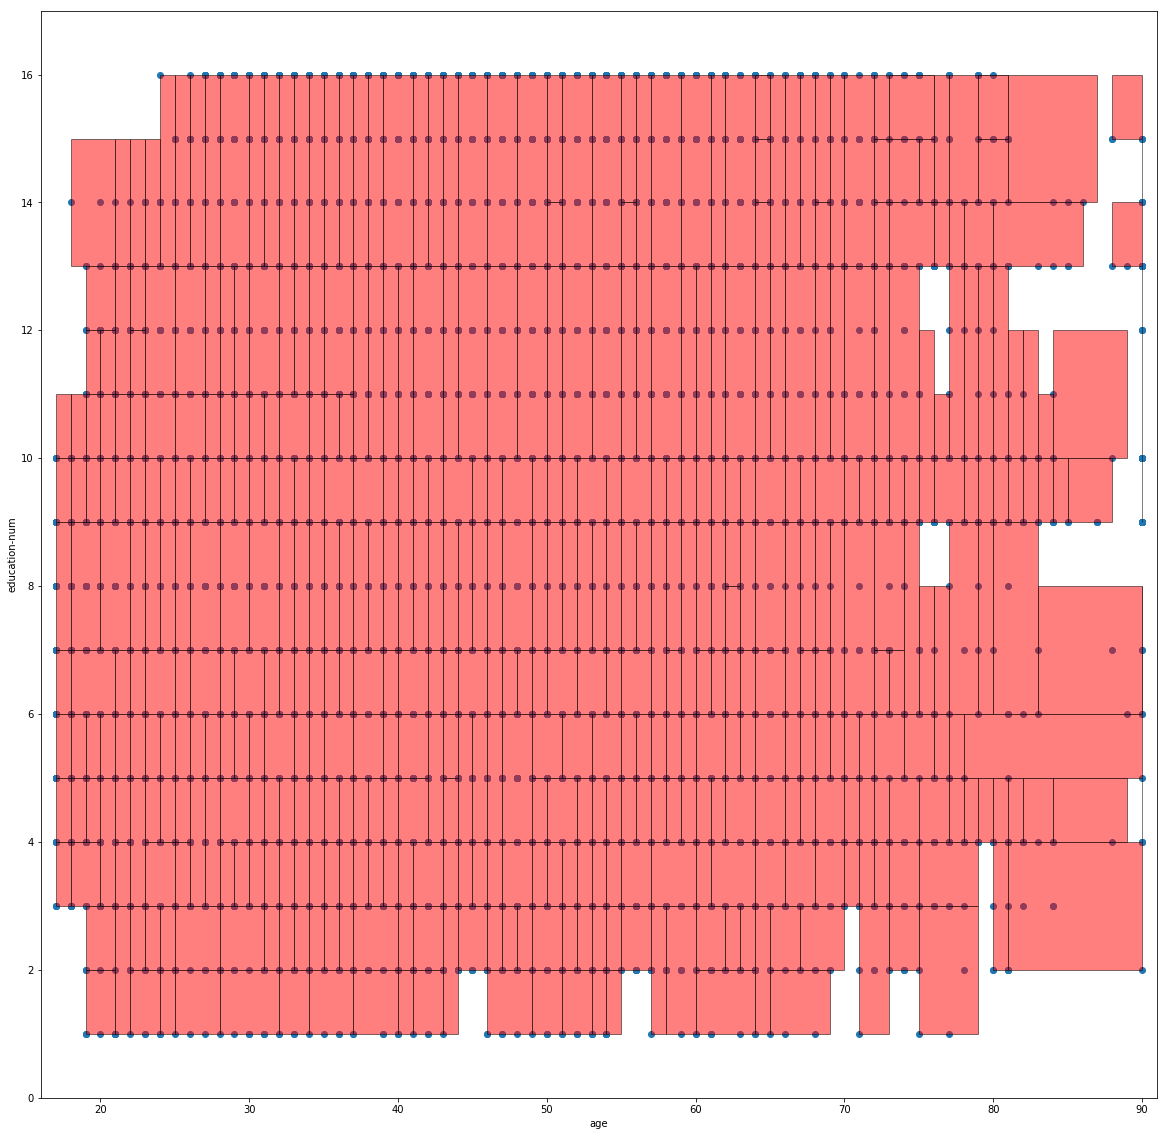

In [215]:
pl.figure(figsize=(20, 20))
ax = pl.subplot(111)

plot_rects(dataset, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(dataset[column_x], dataset[column_y])

pl.show()

In [0]:
# I think the vacant space are deleted partitions. Which does not hold our condition.

### Generating k-Anonymous Dataset
The raw dataset (input) for the k-anonymization must contain one row for each partition and value of the sensitive attribute. <br>
For that let's aggregate the columns in each partition.


In [0]:
# helper methods
# aggregation for the categorical features
def agg_categorical_columns(series):
  return [','.join(set(series))]       # is actually something like 'list(dataset[column].unique())'

# aggregation for the numerical features
def agg_numerical_columns(series):
  return [series.mean()]

In [0]:
def build_anonymized_dataset(dataset, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = dataset.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = dataset.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [218]:
dataset_k = build_anonymized_dataset(dataset, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [219]:
# sort the resulting dataframe using the feature columns and the sensitive attribute
dataset_k.sort_values(feature_columns+[sensitive_column])

,age,count,education-num,income
811,17.000000,3,3.000000,<=50k
809,17.000000,5,4.000000,<=50k
757,17.000000,36,5.000000,<=50k
756,17.000000,198,6.000000,<=50k
715,17.000000,334,7.200599,<=50k
686,17.000000,14,9.000000,<=50k
652,17.000000,5,10.000000,<=50k
808,18.000000,6,4.000000,<=50k
755,18.000000,10,5.000000,<=50k
685,18.000000,249,9.000000,<=50k


In [0]:
# single column partitions exist. I think they do not violate our conditions.

### l-diversity
Let's implement l-diversity in a naive way. For that,
* modify the **is_valid** method. So it will not only check the size of the partition but also the values in partitions are diverse enough.
* modify the **split** function to produce the splits are diverse enough (if possible)

In [0]:
# l-diversity helper methods

# no of classes present in the partition
def diversity(dataset, partition, column):
  return len(dataset[column][partition].unique())

# is_valid method
def is_l_diverse(dataset, partition, sensitive_column, l=2):
  return diversity(dataset, partition, sensitive_column) >= l # will return True if it is diverse

In [0]:
# now let's modify our partition method
# here we will incoporate 'l-diversity' along with the 'k-anonymization' method
# partition_dataset(dataset, feature_columns, sensitive_column, all_spans, is_k_anonymous)

finished_l_diverse_partitions = partition_dataset(dataset, feature_columns, sensitive_column, all_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args) )

In [224]:
len(finished_l_diverse_partitions)

309

In [0]:
# now the visualization part
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(dataset, finished_l_diverse_partitions, column_x, column_y, indices, offsets=[0.0, 0.0])

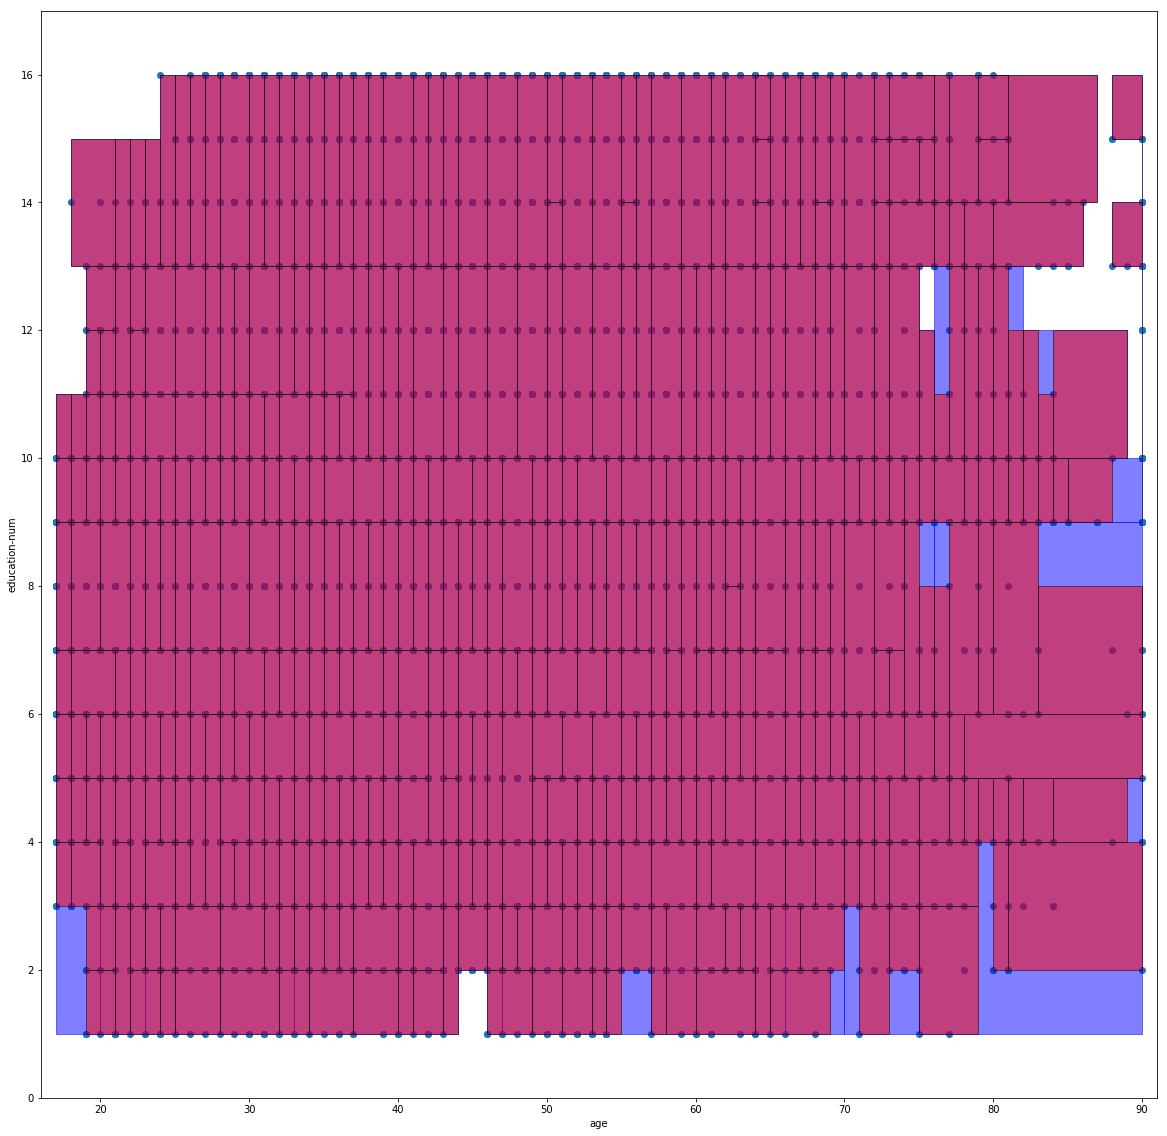

In [227]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(dataset, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(dataset, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(dataset[column_x], dataset[column_y])
pl.show()

In [228]:
# create the anonymized dataset from the l-diverse partitions
dataset_l = build_anonymized_dataset(dataset, finished_l_diverse_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...


In [229]:
# the resulting dataset
dataset_l.sort_values([column_x, column_y, sensitive_column])

,age,count,education-num,income
594,17.706107,785,7.248092,<=50k
595,17.706107,1,7.248092,>50k
616,18.341463,40,3.365854,<=50k
617,18.341463,1,3.365854,>50k
538,19.320276,1301,10.000000,<=50k
539,19.320276,1,10.000000,>50k
566,20.080607,1707,9.000000,<=50k
567,20.080607,5,9.000000,>50k
592,20.364583,95,7.333333,<=50k
593,20.364583,1,7.333333,>50k


### t-closeness
hold the statistical distribution of sensitive attribute in the partitions same as that of the all dataset. <br>

**Implement a version of the is_valid function that returns True if the partition is diverse enough and False otherwise. To measure diversity, calculate the Kolmogorov-Smirnov distance between the empirical probability distribution of the sensitive attribute over the entire dataset vs. the distribution over the partition. Hint: the Kolmogorov-Smirnov distance is the maximum distance between the two distributions. You can assume that the sensitive attribute is a categorical value.**


In [0]:
# calculate the global frequencies for the sensitive attribute
global_freqs = {}
total_count = float(len(dataset))
group_counts = dataset.groupby(sensitive_column)[sensitive_column].agg('count') # counts for the two classes

for value, count in group_counts.to_dict().items():
  p = count/total_count
  global_freqs[value] = p

In [231]:
global_freqs

{'<=50k': 0.7607182343065395, '>50k': 0.23928176569346055}

In [0]:
# the helper methods for the t-closeness

# measure the maximum deviation of the local distribution(partition) from the global distribution(dataset)
def t_closeness(dataset, partition, column, global_freqs):
    # now calculate the local distribution
    total_count = float(len(partition))
    d_max = None
    group_counts = dataset.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value]) # is the maximum deviation of the partition from the global distribution
        if d_max is None or d > d_max:
            d_max = d
    return d_max


# is_valid method
def is_t_close(dataset, partition, sensitive_column, global_freqs, p=0.2):
  """
  :param               p: The maximum allowed Kolmogorov-Smirnov distance
  """
  if not sensitive_column in categorical:
    raise ValueError("this method only works for categorical values")
  return t_closeness(dataset, partition, sensitive_column, global_freqs) <= p

In [0]:
# now create the anonymized dataset
finished_t_close_partitions = partition_dataset(dataset, feature_columns, sensitive_column, all_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [245]:
len(finished_t_close_partitions)

114

In [246]:
# the dataset
dataset_t = build_anonymized_dataset(dataset, finished_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...


In [247]:
# the results
dataset_t.sort_values([column_x, column_y, sensitive_column])

,age,count,education-num,income
222,24.543287,738,11.476788,<=50k
223,24.543287,59,11.476788,>50k
224,25.747108,5617,10.000000,<=50k
225,25.747108,520,10.000000,>50k
226,26.697666,10248,8.124394,<=50k
227,26.697666,677,8.124394,>50k
220,29.000000,112,11.367647,<=50k
221,29.000000,24,11.367647,>50k
208,29.434809,3385,13.299485,<=50k
209,29.434809,1470,13.299485,>50k


In [0]:
# visualize the results
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(dataset, finished_t_close_partitions, column_x, column_y, indices, offsets=[0.0, 0.0])

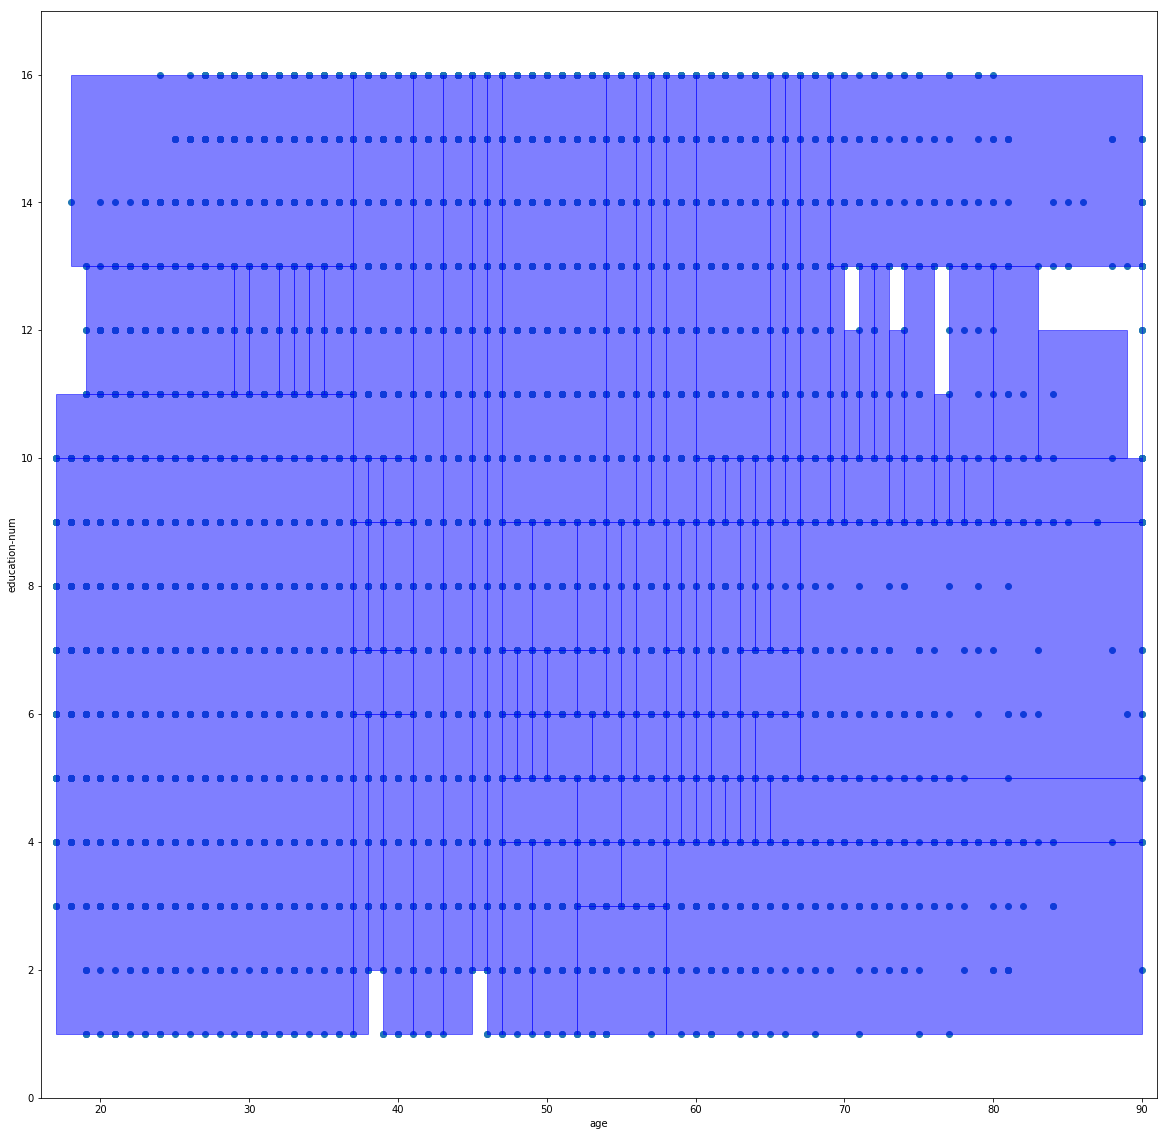

In [251]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(dataset, ax, t_close_rects, column_x, column_y, edgecolor='b', facecolor='b')
pl.scatter(dataset[column_x], dataset[column_y])
pl.show()

In [0]:
# Done!